In [1]:
import numpy as np
import pandas as pd
import gvar as gv
import lsqfit
import matplotlib.pyplot as plt
%matplotlib notebook
from tqdm import tqdm_notebook as tqdm
import pcr_lib as pcr
import yaml

# switches

In [2]:
switches = dict()
# PLOTTING OPTIONS
switches['plot'] = dict()
switches['plot']['correlator'] = False # data (effective mass, Zs, etc...)
switches['plot']['stability'] = True # correlator stability after fit
# FITTING OPTIONS
switches['fit'] = dict()
switches['fit']['switch'] = True # turn fitting on/off
# choose dataset
switches['fit']['clist']   = ['nucleon','dnucleon','gV','dgV'] # the derivatives should be fit with the correlators or else there's no handel on the parameters
switches['fit']['snk_src'] = ['SS']
switches['fit']['mom']     = [0,1] #,2] # n in 2*n*pi/L
switches['fit']['nstate']  = 2
switches['fit']['ens'] = '3296' # 3296 or 4896
# time region
switches['fit']['T_3pt']   = [8,10] #,14] # t_snk for 3pt: only 8, 10 or 14
switches['fit']['trange'] = dict()
if switches['fit']['ens'] in ['3296']:
    switches['fit']['trange']['nucleon_tmin']   = [4,4] # snk location
    switches['fit']['trange']['nucleon_tmax']   = [6,6] # snk location
    switches['fit']['trange']['dnucleon_tmin']   = [5,5] # snk location
    switches['fit']['trange']['dnucleon_tmax']   = [7,7] # snk location
    switches['fit']['trange']['gV_T8_tmin']   = [3,3] # current insertion time
    switches['fit']['trange']['gV_T8_tmax']   = [5,5] # current insertion time
    switches['fit']['trange']['gV_T10_tmin']   = [4,4] # current insertion time
    switches['fit']['trange']['gV_T10_tmax']   = [6,6] # current insertion time
    switches['fit']['trange']['gV_T14_tmin']   = [5,5] # current insertion time
    switches['fit']['trange']['gV_T14_tmax']   = [7,7] # current insertion time
    switches['fit']['trange']['dgV_T8_tmin']   = [2,2] # current insertion time
    switches['fit']['trange']['dgV_T8_tmax']   = [4,4] # current insertion time
    switches['fit']['trange']['dgV_T10_tmin']   = [2,2] # current insertion time
    switches['fit']['trange']['dgV_T10_tmax']   = [4,4] # current insertion time
    switches['fit']['trange']['dgV_T14_tmin']   = [5,5] # current insertion time
    switches['fit']['trange']['dgV_T14_tmax']   = [7,7] # current insertion time
elif switches['fit']['ens'] in ['4896']:
    switches['fit']['trange']['nucleon_tmin']   = [6,6] # snk location
    switches['fit']['trange']['nucleon_tmax']   = [9,9] # snk location
    switches['fit']['trange']['dnucleon_tmin']   = [5,5] # snk location
    switches['fit']['trange']['dnucleon_tmax']   = [8,8] # snk location
    switches['fit']['trange']['gV_T8_tmin']   = [3,3] # current insertion time
    switches['fit']['trange']['gV_T8_tmax']   = [5,5] # current insertion time
    switches['fit']['trange']['gV_T10_tmin']   = [4,4] # current insertion time
    switches['fit']['trange']['gV_T10_tmax']   = [6,6] # current insertion time
    switches['fit']['trange']['gV_T14_tmin']   = [5,5] # current insertion time
    switches['fit']['trange']['gV_T14_tmax']   = [7,7] # current insertion time
    switches['fit']['trange']['dgV_T8_tmin']   = [3,3] # current insertion time
    switches['fit']['trange']['dgV_T8_tmax']   = [5,5] # current insertion time
    switches['fit']['trange']['dgV_T10_tmin']   = [4,4] # current insertion time
    switches['fit']['trange']['dgV_T10_tmax']   = [6,6] # current insertion time
    switches['fit']['trange']['dgV_T14_tmin']   = [5,5] # current insertion time
    switches['fit']['trange']['dgV_T14_tmax']   = [7,7] # current insertion time
# PRIORS
switches['p'] = dict()
# nucleon q = 0
switches['p']['E0_q0'] = gv.gvar(0.7,0.14)
switches['p']['Z0s_q0'] = gv.gvar(2.2E-4,1.1E-4) # z = Z/sqrt(2E)
switches['p']['E1_q0'] = gv.gvar(-0.7,1.5) # log splitting to two pions
switches['p']['Z1s_q0'] = gv.gvar(0.0,1.1E-4)
switches['p']['E2_q0'] = gv.gvar(-0.7,1.5) # log splitting to two pions
switches['p']['Z2s_q0'] = gv.gvar(0.0,0.55E-4)
switches['p']['E3_q0'] = gv.gvar(-0.7,1.5) # log splitting to two pions
switches['p']['Z3s_q0'] = gv.gvar(0.0,0.275E-4)
# nucleon q = 1
switches['p']['E0_q1'] = gv.gvar(0.75,0.15)
switches['p']['Z0s_q1'] = gv.gvar(2E-4,1E-4)
switches['p']['E1_q1'] = gv.gvar(-0.8,1.6) # splitting to zero momentum 2 pion and 1 pion
switches['p']['Z1s_q1'] = gv.gvar(0.0,1E-4)
switches['p']['E2_q1'] = gv.gvar(-0.8,1.6) # splitting to zero momentum 2 pion and 1 pion
switches['p']['Z2s_q1'] = gv.gvar(0.0,0.5E-4)
switches['p']['E3_q1'] = gv.gvar(-0.8,1.6) # splitting to zero momentum 2 pion and 1 pion
switches['p']['Z3s_q1'] = gv.gvar(0.0,0.25E-4)
# dnucleon q = 0 (Y comes before Z... so it's a derivative? something like that)
switches['p']['Y0s_q0'] = gv.gvar(-1.5,0.5) # z' = Z'/[z*sqrt(2E)]
switches['p']['Y1s_q0'] = gv.gvar(-1.5,0.5)
switches['p']['Y2s_q0'] = gv.gvar(-1.5,0.5)
switches['p']['Y3s_q0'] = gv.gvar(-1.5,0.5)
# dnucleon q = 1
switches['p']['Y0s_q1'] = gv.gvar(-1.5,0.5)
switches['p']['Y1s_q1'] = gv.gvar(-1.5,0.5)
switches['p']['Y2s_q1'] = gv.gvar(-1.5,0.5)
switches['p']['Y3s_q1'] = gv.gvar(-1.5,0.5)
# gV q = 0
switches['p']['V00_q0'] = gv.gvar(0.6,0.6)
switches['p']['V10_q0'] = gv.gvar(0.0,0.6)
switches['p']['V11_q0'] = gv.gvar(0.0,0.6)
switches['p']['V20_q0'] = gv.gvar(0.0,0.6)
switches['p']['V21_q0'] = gv.gvar(0.0,0.6)
switches['p']['V22_q0'] = gv.gvar(0.0,0.6)
switches['p']['V30_q0'] = gv.gvar(0.0,0.6)
switches['p']['V31_q0'] = gv.gvar(0.0,0.6)
switches['p']['V32_q0'] = gv.gvar(0.0,0.6)
switches['p']['V33_q0'] = gv.gvar(0.0,0.6)
# gV q = 1
switches['p']['V00_q1'] = gv.gvar(0.5,0.5)
switches['p']['V10_q1'] = gv.gvar(0.0,0.5)
switches['p']['V11_q1'] = gv.gvar(0.0,0.5)
switches['p']['V20_q1'] = gv.gvar(0.0,0.5)
switches['p']['V21_q1'] = gv.gvar(0.0,0.5)
switches['p']['V22_q1'] = gv.gvar(0.0,0.5)
switches['p']['V30_q1'] = gv.gvar(0.0,0.5)
switches['p']['V31_q1'] = gv.gvar(0.0,0.5)
switches['p']['V32_q1'] = gv.gvar(0.0,0.5)
switches['p']['V33_q1'] = gv.gvar(0.0,0.5)
# dgV q = 0
switches['p']['U00_q0'] = gv.gvar(-5,5)
switches['p']['U10_q0'] = gv.gvar(-0,5)
switches['p']['U11_q0'] = gv.gvar(-0,5)
switches['p']['U20_q0'] = gv.gvar(-0,5)
switches['p']['U21_q0'] = gv.gvar(-0,5)
switches['p']['U22_q0'] = gv.gvar(-0,5)
switches['p']['U30_q0'] = gv.gvar(-0,5)
switches['p']['U31_q0'] = gv.gvar(-0,5)
switches['p']['U32_q0'] = gv.gvar(-0,5)
switches['p']['U33_q0'] = gv.gvar(-0,5)
# dgV q = 1
switches['p']['U00_q1'] = gv.gvar(-5,5)
switches['p']['U10_q1'] = gv.gvar(-0,5)
switches['p']['U11_q1'] = gv.gvar(-0,5)
switches['p']['U20_q1'] = gv.gvar(-0,5)
switches['p']['U21_q1'] = gv.gvar(-0,5)
switches['p']['U22_q1'] = gv.gvar(-0,5)
switches['p']['U30_q1'] = gv.gvar(-0,5)
switches['p']['U31_q1'] = gv.gvar(-0,5)
switches['p']['U32_q1'] = gv.gvar(-0,5)
switches['p']['U33_q1'] = gv.gvar(-0,5)

# read csv file into dataframe
## ensemble information
+ 0.12fm lattice spacing
+ pion mass 400 MeV
+ isoclover

## configuration information
#### for 3296
+ 1000 to 2950 skip 10 (196 configurations)
    + configuration 1470 is missing for baryon 2pt tsrc 48, idx = 47
    
#### for 4896
+ 1370 to 2390 skip 10 (102 configurations)
    + configuration 1930 is broken

#### data file names (same for both)
+ two point correlation function
    + `bar_s22_SS_tsrc_[0,48].dat.[re,im]`
    + two sources at `[0,48]`
    + each line contains:
        + individual momentum `[0,1,-1,2,-2]`
        + individual time slice
        + array of z-dependence
        + *e.g.* `bar_s22_S0src_S0_px0_py0_pz0_t0_re`
+ three point correlation function
    + `barff_s22_SS_g8_T[10,14]_tsrc_[0,48].dat.[re,im]`
    + `g8` corresponds to the `V4` current insertion
    + `T[10,14]` is snk location
    + two sources at `[0,48]`
    + each line contains:
        + individual momentum transfer (snk at zero momentum) `[0,1,-1,2,-2]`
        + individual time slice
        + array of z-dependence at current insertion
        + *e.g.* `barff_s2_S0src_S0snk_T10_px0_py0_pz0_g8_t0_re`

## strategy
+ read zero momentum spatial correlator
+ perform source average
+ construct two and three point (with momentum transfer)
+ construct moment correlators

## notes
+ read SS src snk

In [3]:
zdata = pcr.read_csv(switches)

2pt: bar_s22_S0src_S0_px0_py0_pz0_re (195, 96, 32)
3pt: barff_s2_S0src_S0snk_T8_px0_py0_pz0_g8_re (195, 96, 32)
3pt: barff_s2_S0src_S0snk_T10_px0_py0_pz0_g8_re (195, 96, 32)


# construct two and three point correlators
+ Lattice 2016 proceedings @ https://arxiv.org/pdf/1610.02354.pdf
+ project to definite momentum

In [4]:
data = dict()
nl = int(switches['fit']['ens'][:2])
# two point correlation function
if 'nucleon' in switches['fit']['clist']:
    for snk_src in switches['fit']['snk_src']:
        snk = snk_src[0]
        src = snk_src[1]
        for n in switches['fit']['mom']:
            k = 2.*np.pi*n/nl
            pos = zdata['bar_s22_%s0src_%s0_px0_py0_pz0_re' %(src,snk)]*np.cos(k*np.arange(nl))
            neg = zdata['bar_s22_%s0src_%s0_px0_py0_pz0_re' %(src,snk)]*np.cos(-k*np.arange(nl))
            data['nucleon_%s_q%s' %(str(snk_src),str(n))] = np.sum((pos+neg)/2,axis=2) # mom avg & project to 3 momentum
# gV correlation function
if 'gV' in switches['fit']['clist']:
    for snk_src in switches['fit']['snk_src']:
        snk = snk_src[0]
        src = snk_src[1]
        for n in switches['fit']['mom']:
            k = 2.*np.pi*n/nl
            for T in switches['fit']['T_3pt']:
                pos = zdata['barff_s2_%s0src_%s0snk_T%s_px0_py0_pz0_g8_re' %(src,snk,str(T))]*np.cos(k*np.arange(nl))
                neg = zdata['barff_s2_%s0src_%s0snk_T%s_px0_py0_pz0_g8_re' %(src,snk,str(T))]*np.cos(-k*np.arange(nl))
                data['gV_%s_T%s_q%s' %(str(snk_src),str(T),str(n))] = np.sum((pos+neg)/2,axis=2) # mom avg & project to 3 momentum
data.keys()

dict_keys(['nucleon_SS_q0', 'nucleon_SS_q1', 'gV_SS_T8_q0', 'gV_SS_T10_q0', 'gV_SS_T8_q1', 'gV_SS_T10_q1'])

# construct moments of correlation functions

In [5]:
# two point moment data
z = np.roll(np.arange(nl)-nl/2+1,nl//2+1)
rz2 = z**2
# apply moment
# output is Ncf * T * Z
if 'dnucleon' in switches['fit']['clist']:
    for q in switches['fit']['mom']:
        for snk_src in switches['fit']['snk_src']:
            snk = snk_src[0]
            src = snk_src[1]
            if q == 0:
                D = -0.5*rz2
            else:
                k = 2.*np.pi*q/nl
                D = -z/(2.*k)*np.sin(k*np.arange(nl))
            if 'dnucleon' in switches['fit']['clist']:
                temp = D*zdata['bar_s22_%s0src_%s0_px0_py0_pz0_re' %(src,snk)]
                # UNCOMMENT TO PLOT Z DEPENDENCE
                #pcr.plot_2pt_z(temp,title='2pt') #title='dnucleon_%s_q%s' %(snk_src,str(q)))
                # project to 3 momentum
                data['dnucleon_%s_q%s' %(snk_src,str(q))] = np.sum(temp,axis=2)
            if 'dgV' in switches['fit']['clist']:
                for T in switches['fit']['T_3pt']:
                    temp = D*zdata['barff_s2_%s0src_%s0snk_T%s_px0_py0_pz0_g8_re' %(src,snk,str(T))]
                    if switches['plot']['correlator']:
                        pcr.plot_3pt_z(np.abs(temp),q,title='3pt') #title='dgV_%s_T%s_q%s' %(snk_src,str(T),str(q)))
                    # project 3 momentum
                    data['dgV_%s_T%s_q%s' %(snk_src,str(T),str(q))] = np.sum(temp,axis=2)
print(data.keys())

dict_keys(['nucleon_SS_q0', 'nucleon_SS_q1', 'gV_SS_T8_q0', 'gV_SS_T10_q0', 'gV_SS_T8_q1', 'gV_SS_T10_q1', 'dnucleon_SS_q0', 'dgV_SS_T8_q0', 'dgV_SS_T10_q0', 'dnucleon_SS_q1', 'dgV_SS_T8_q1', 'dgV_SS_T10_q1'])


# construct correlated dataset

In [6]:
gvdata = gv.dataset.avg_data(data)
for k in gvdata.keys():
    print(k,np.shape(gvdata[k]))

nucleon_SS_q0 (96,)
nucleon_SS_q1 (96,)
gV_SS_T8_q0 (96,)
gV_SS_T10_q0 (96,)
gV_SS_T8_q1 (96,)
gV_SS_T10_q1 (96,)
dnucleon_SS_q0 (96,)
dgV_SS_T8_q0 (96,)
dgV_SS_T10_q0 (96,)
dnucleon_SS_q1 (96,)
dgV_SS_T8_q1 (96,)
dgV_SS_T10_q1 (96,)


# plot correlation function

In [7]:
# plot params
figsize = (3.50394*2,2*2.1655535534)
ms = '6'
cs = 6
fs_l = 14
fs_xy = 14
ts = 14
lw = 1
plt_axes = [0.14,0.155,0.825,0.825]
# state and q label
pparam = dict()
# state
pparam['color'] = dict()
pparam['color']['q0'] = '#ec5d57' # red
#pparam['color']['2state'] = '#70bf41' # green
pparam['color']['q1'] = '#51a7f9' # blue
#pparam['color']['4state'] = '#b36ae2' # purple
# q
pparam['shape'] = dict()
pparam['shape']['q0'] = 'o'
pparam['shape']['q1'] = 's'
# label translator
pparam['label'] = dict()
pparam['label']['2pt'] = 'C_{\mathrm{2pt}}(t)'
pparam['label']['d2pt'] = 'C^\prime_{\mathrm{2pt}}(t)'
pparam['label']['gV8'] = 'C_{\mathrm{3pt}}(8,t^\prime)'
pparam['label']['dgV8'] = 'C^\prime_{\mathrm{3pt}}(8,t^\prime)'
pparam['label']['gV10'] = 'C_{\mathrm{3pt}}(10,t^\prime)'
pparam['label']['dgV10'] = 'C^\prime_{\mathrm{3pt}}(10,t^\prime)'

In [8]:
dat2name = [i for i in gvdata.keys() if i.split('_')[0] in ['nucleon']]
datd2name = [i for i in gvdata.keys() if i.split('_')[0] in ['dnucleon']]
dat3name = [i for i in gvdata.keys() if i.split('_')[0] in ['gV']]
datd3name = [i for i in gvdata.keys() if i.split('_')[0] in ['dgV']]

if switches['plot']['correlator']:
    # plot effective mass correlator
    fig = plt.figure('meff',figsize=figsize)
    ax = plt.axes(plt_axes)
    x = np.arange(0,24)
    xmin = switches['fit']['trange']['nucleon_tmin'][0]-0.5
    xmax = switches['fit']['trange']['nucleon_tmax'][0]+0.5
    ax.errorbar(x=[xmin,xmin],y=[-10,10],ls='--',color='black',alpha=0.3)
    ax.errorbar(x=[xmax,xmax],y=[-10,10],ls='--',color='black',alpha=0.3)
    ax.fill_between([-1,20],0.7351-0.0078,0.7351+0.0078,alpha=0.3,facecolor=pparam['color']['q0']) # q=0
    ax.fill_between([-1,20],0.760833-0.00762053 ,0.760833+0.00762053 ,alpha=0.3,facecolor=pparam['color']['q1']) # q=1
    for d in dat2name:
        print(d)
        meff = np.log(gvdata[d]/np.roll(gvdata[d],-1))[x]
        ax.errorbar(x+0.2*(float(d[-1])-0.5),y=[i.mean for i in meff],yerr=[i.sdev for i in meff],\
                    label=d,marker=pparam['shape']['q%s' %d[-1]],color=pparam['color']['q%s' %d[-1]],\
                   capsize=cs,markersize=ms,elinewidth=lw,mew=lw,fillstyle='none', ls='none')
    #ax.legend()
    ax.set_xlabel(r'$t/a$', fontsize=fs_xy)
    ax.set_ylabel(r'$m^{\mathrm{eff}}$', fontsize=fs_xy)
    ax.set_xlim([0.3,18.7])
    ax.set_ylim([0.5,1.0])
    #ax.set_xticks(xticks)
    ax.xaxis.set_tick_params(labelsize=ts,width=lw)
    ax.yaxis.set_tick_params(labelsize=ts,width=lw)
    [ax.spines[key].set_linewidth(lw) for key in ax.spines]
    plt.draw()
    
    # plot scaled two point correlator
    fig = plt.figure('zeff',figsize=figsize)
    ax = plt.axes(plt_axes)
    x = np.arange(0,24)
    xmin = switches['fit']['trange']['nucleon_tmin'][0]-0.5
    xmax = switches['fit']['trange']['nucleon_tmax'][0]+0.5
    ax.errorbar(x=[xmin,xmin],y=[-1,1],ls='--',color='black',alpha=0.3)
    ax.errorbar(x=[xmax,xmax],y=[-1,1],ls='--',color='black',alpha=0.3)
    ax.fill_between([-1,20],0.000214887-4.1269e-06,0.000214887+4.1269e-06,alpha=0.3,facecolor=pparam['color']['q0']) # q=0
    ax.fill_between([-1,20],0.000199366-4.1459e-06,0.000199366+4.1459e-06,alpha=0.3,facecolor=pparam['color']['q1']) # q=1
    for d in dat2name:
        snk_src = d.split('_')[1]
        if snk_src in ['SS','PP']:
            meff = np.log(gvdata[d]/np.roll(gvdata[d],-1))
            scor = np.sqrt(gvdata[d]*np.exp(meff*np.arange(len(meff))))[x]
            ax.errorbar(x+0.2*(float(d[-1])-0.5),y=[i.mean for i in scor],yerr=[i.sdev for i in scor],label=d,\
                        marker=pparam['shape']['q%s' %d[-1]],color=pparam['color']['q%s' %d[-1]],\
                        capsize=cs,markersize=ms,elinewidth=lw,mew=lw,fillstyle='none', ls='none')
        else:
            pass
    #ax.legend()
    ax.set_xlabel(r'$t/a$', fontsize=fs_xy)
    ax.set_ylabel(r'$z^{\mathrm{eff}}$', fontsize=fs_xy)
    #ax.set_xticks(xticks)
    ax.xaxis.set_tick_params(labelsize=ts,width=lw)
    ax.yaxis.set_tick_params(labelsize=ts,width=lw)
    ax.set_xlim([0.3,18.7])
    ax.set_ylim([0,3E-4])
    [ax.spines[key].set_linewidth(lw) for key in ax.spines]
    plt.draw()
    
    # plot two point slope
    fig = plt.figure('zeffprime',figsize=figsize)
    ax = plt.axes(plt_axes)
    x = np.arange(0,24)
    xmin = switches['fit']['trange']['dnucleon_tmin'][0]-0.5
    xmax = switches['fit']['trange']['dnucleon_tmax'][0]+0.5
    ax.errorbar(x=[xmin,xmin],y=[-10,1],ls='--',color='black',alpha=0.3)
    ax.errorbar(x=[xmax,xmax],y=[-10,1],ls='--',color='black',alpha=0.3)
    ax.fill_between([0,30],-1.4717-0.0357325,-1.4717+0.0357325,alpha=0.3,facecolor=pparam['color']['q0']) # q=0
    ax.fill_between([0,30],-1.48106-0.034865,-1.48106+0.034865,alpha=0.3,facecolor=pparam['color']['q1']) # q=1
    for dd in datd2name:
        snk_src = dd.split('_')[1]
        d = dd[1:] # two point name (take out derivative)
        if snk_src in ['SS','PP']:
            meff = np.log(gvdata[d]/np.roll(gvdata[d],-1))
            scor = np.sqrt(gvdata[d]*np.exp(meff*np.arange(len(meff))))
            dcor = ((gvdata[dd]/gvdata[d]+0.5/meff**2+0.5*np.arange(len(meff))/meff)*0.5)[x]
            ax.errorbar(x+0.2*(float(d[-1])-0.5),y=[i.mean for i in dcor],yerr=[i.sdev for i in dcor],label=dd,\
                        marker=pparam['shape']['q%s' %d[-1]],color=pparam['color']['q%s' %d[-1]],\
                        capsize=cs,markersize=ms,elinewidth=lw,mew=lw,fillstyle='none', ls='none')
        else:
            pass
    #ax.legend()
    ax.set_xlabel(r'$t/a$', fontsize=fs_xy)
    ax.set_ylabel(r'$z^{\prime\mathrm{eff}}$', fontsize=fs_xy)
    ax.set_xlim([0.3,18.7])
    ax.set_ylim([-2,-0.5])
    #ax.set_xticks(xticks)
    ax.xaxis.set_tick_params(labelsize=ts,width=lw)
    ax.yaxis.set_tick_params(labelsize=ts,width=lw)
    [ax.spines[key].set_linewidth(lw) for key in ax.spines]
    plt.draw()
    
    # plot three point correlator
    fig = plt.figure('gV correlator',figsize=figsize)
    ax = plt.axes(plt_axes)
    for d in dat3name:
        snk_src = d.split('_')[1]
        Tx = d.split('_')[2]
        T = int(Tx[1:])
        qx = d.split('_')[3]
        q = int(qx[1:])
        x = np.arange(T+1)
        xmin8 = switches['fit']['trange']['gV_T%s_tmin' %T][0]-0.5
        xmax8 = switches['fit']['trange']['gV_T%s_tmax' %T][0]+0.5
        if q == 0:
            if T == 8: ls = '-'
            elif T == 10: ls = '--'
            ax.errorbar(x=[xmin8,xmin8],y=[-10,10],ls=ls,color='black',alpha=0.3)
            ax.errorbar(x=[xmax8,xmax8],y=[-10,10],ls=ls,color='black',alpha=0.3)
    for d in dat3name:
        snk_src = d.split('_')[1]
        Tx = d.split('_')[2]
        T = int(Tx[1:])
        qx = d.split('_')[3]
        q = int(qx[1:])
        if q == 0 and T == 8:
            ax.fill_between([-10,30],0.574268-0.0295098,0.574268+0.0295098,alpha=0.3,facecolor=pparam['color']['q0']) # q=0
            ax.fill_between([-10,30],0.474146-0.0256038,0.474146+0.0256038,alpha=0.3,facecolor=pparam['color']['q1']) # q=1
        if snk_src in ['SS','PP']:
            d2 = d.replace('gV','nucleon').replace('_%s' %Tx,'') # two point correlator name
            d20 = d2.replace(qx,'q0') # zero momentum two point name
            Tlist = np.arange(len(gvdata[d2]))
            Esnk = np.mean(np.log(gvdata[d20]/np.roll(gvdata[d20],-1))[6:9]) # sink is always at zero momentum
            Esrc = np.mean(np.log(gvdata[d2]/np.roll(gvdata[d2],-1))[6:9])
            Zsnk = np.mean(np.sqrt(gvdata[d20]*np.exp(Esnk*Tlist))[6:9]) # sink is always at zero momentum
            Zsrc = np.mean(np.sqrt(gvdata[d2]*np.exp(Esrc*Tlist))[6:9])
            tlist = np.arange(len(gvdata[d]))
            geff = (gvdata[d]*np.exp(Esnk*T)*np.exp((Esrc-Esnk)*tlist)/(Zsnk*Zsrc))[x]
            if T == 8: fs = 'full'
            elif T == 10: fs = 'none'
            ax.errorbar(x+(0.2*q-0.1)+0.05*(T-9),y=[i.mean for i in geff],yerr=[i.sdev for i in geff],label=d,\
                        marker=pparam['shape']['q%s' %d[-1]],color=pparam['color']['q%s' %d[-1]],\
                        capsize=cs,markersize=ms,elinewidth=lw,mew=lw,fillstyle=fs, ls='none')
            #ax.legend()
    ax.set_xlabel(r'$t/a$', fontsize=fs_xy)
    ax.set_ylabel(r'$g_V^{\mathrm{eff}}$', fontsize=fs_xy)
    ax.set_xlim([-0.7,T+0.7])
    ax.set_ylim([0.4,0.7])
    #ax.set_xticks(xticks)
    ax.xaxis.set_tick_params(labelsize=ts,width=lw)
    ax.yaxis.set_tick_params(labelsize=ts,width=lw)
    [ax.spines[key].set_linewidth(lw) for key in ax.spines]
    plt.draw()
            
    # plot three point derivative correlator
    fig = plt.figure('dgV correlator',figsize=figsize)
    ax = plt.axes(plt_axes)
    for d in dat3name:
        snk_src = d.split('_')[1]
        Tx = d.split('_')[2]
        T = int(Tx[1:])
        qx = d.split('_')[3]
        q = int(qx[1:])
        x = np.arange(T+1)
        xmin8 = switches['fit']['trange']['dgV_T%s_tmin' %T][0]-0.5
        xmax8 = switches['fit']['trange']['dgV_T%s_tmax' %T][0]+0.5
        if q == 0:
            if T == 8: ls = '-'
            elif T == 10: ls = '--'
            ax.errorbar(x=[xmin8,xmin8],y=[-10,10],ls=ls,color='black',alpha=0.3)
            ax.errorbar(x=[xmax8,xmax8],y=[-10,10],ls=ls,color='black',alpha=0.3)
    for dd in datd3name:
        d = dd[1:] # three point correlator name
        snk_src = dd.split('_')[1]
        Tx = dd.split('_')[2]
        T = int(Tx[1:])
        qx = dd.split('_')[3]
        q = int(qx[1:])
        x = np.arange(T+1)
        if q == 0 and T == 8:
            ax.fill_between([-10,30],-4.4139-0.217968,-4.4139+0.217968,alpha=0.3,facecolor=pparam['color']['q0']) # q=0
            ax.fill_between([-10,30],-4.08252-0.247958,-4.08252+0.247958 ,alpha=0.3,facecolor=pparam['color']['q1']) # q=1
        if snk_src in ['SS','PP']:
            d2 = d.replace('gV','nucleon').replace('_%s' %Tx,'') # two point correlator name
            dd2 = 'd%s' %d2 # two point derivative name
            Tlist = np.arange(len(gvdata[d2]))
            Esrc = np.log(gvdata[d2]/np.roll(gvdata[d2],-1))
            Zsrc = np.sqrt(gvdata[d2]*np.exp(Esrc*Tlist))
            dZsrc = ((gvdata[dd2]/gvdata[d2]+0.5/Esrc**2+0.5*np.arange(len(Esrc))/Esrc)*0.5)
            Emean = np.mean(Esrc[6:9])
            dZmean = np.mean(dZsrc[6:9])
            tlist = np.arange(len(gvdata[d]))
            dgeff = (gvdata[dd]/gvdata[d]-dZmean+0.5/Emean**2+0.5*tlist/Emean)[x]
            if T == 8: fs = 'full'
            elif T == 10: fs = 'none'
            #ax.errorbar(x+0.1*q,y=[i.mean for i in dgeff],yerr=[i.sdev for i in dgeff],label=d,capsize=4,marker='o')
            ax.errorbar(x+(0.2*q-0.1)+0.05*(T-9),y=[i.mean for i in dgeff],yerr=[i.sdev for i in dgeff],label=d,\
                        marker=pparam['shape']['q%s' %d[-1]],color=pparam['color']['q%s' %d[-1]],\
                        capsize=cs,markersize=ms,elinewidth=lw,mew=lw,fillstyle=fs, ls='none')
            #ax.legend()
    ax.set_xlabel(r'$t/a$', fontsize=fs_xy)
    ax.set_ylabel(r'$g_V^{\prime\mathrm{eff}}$', fontsize=fs_xy)
    ax.set_xlim([-0.7,T+0.7])
    ax.set_ylim([-6.5,-2])
    #ax.set_xticks(xticks)
    ax.xaxis.set_tick_params(labelsize=ts,width=lw)
    ax.yaxis.set_tick_params(labelsize=ts,width=lw)
    [ax.spines[key].set_linewidth(lw) for key in ax.spines]
    plt.draw()

# fit correlators
+ blahblah... I'm too lazy for this... I will regret it later

In [9]:
# instantiate fitter
fitter = pcr.fitter_class(switches['fit']['clist'],switches['fit']['snk_src'],\
                          switches['fit']['mom'],switches['fit']['nstate'])
# result
result = dict()
# loop over t-range
nucleon_tmin = switches['fit']['trange']['nucleon_tmin']
nucleon_tmax = switches['fit']['trange']['nucleon_tmax']
dnucleon_tmin = switches['fit']['trange']['dnucleon_tmin']
dnucleon_tmax = switches['fit']['trange']['dnucleon_tmax']
gV_T8_tmin = switches['fit']['trange']['gV_T8_tmin']
gV_T8_tmax = switches['fit']['trange']['gV_T8_tmax']
gV_T10_tmin = switches['fit']['trange']['gV_T10_tmin']
gV_T10_tmax = switches['fit']['trange']['gV_T10_tmax']
gV_T14_tmin = switches['fit']['trange']['gV_T14_tmin']
gV_T14_tmax = switches['fit']['trange']['gV_T14_tmax']
dgV_T8_tmin = switches['fit']['trange']['dgV_T8_tmin']
dgV_T8_tmax = switches['fit']['trange']['dgV_T8_tmax']
dgV_T10_tmin = switches['fit']['trange']['dgV_T10_tmin']
dgV_T10_tmax = switches['fit']['trange']['dgV_T10_tmax']
dgV_T14_tmin = switches['fit']['trange']['dgV_T14_tmin']
dgV_T14_tmax = switches['fit']['trange']['dgV_T14_tmax']
worklist = [{'t2min':t2min, 't2max':t2max,\
             'dt2min': dt2min, 'dt2max': dt2max,\
             't3min8': t3min8, 't3max8': t3max8,\
             't3min10': t3min10, 't3max10': t3max10,\
             't3min14': t3min14, 't3max14': t3max14,\
             'dt3min8': dt3min8, 'dt3max8': dt3max8,\
             'dt3min10': dt3min10, 'dt3max10': dt3max10,\
             'dt3min14': dt3min14, 'dt3max14': dt3max14}\
           for t2min in np.arange(nucleon_tmin[0],nucleon_tmin[1]+1)\
           for t2max in np.arange(nucleon_tmax[0],nucleon_tmax[1]+1)\
           for dt2min in np.arange(dnucleon_tmin[0],dnucleon_tmin[1]+1)\
           for dt2max in np.arange(dnucleon_tmax[0],dnucleon_tmax[1]+1)\
           for t3min8 in np.arange(gV_T8_tmin[0],gV_T8_tmin[1]+1)\
           for t3max8 in np.arange(gV_T8_tmax[0],gV_T8_tmax[1]+1)\
           for t3min10 in np.arange(gV_T10_tmin[0],gV_T10_tmin[1]+1)\
           for t3max10 in np.arange(gV_T10_tmax[0],gV_T10_tmax[1]+1)\
           for t3min14 in np.arange(gV_T14_tmin[0],gV_T14_tmin[1]+1)\
           for t3max14 in np.arange(gV_T14_tmax[0],gV_T14_tmax[1]+1)\
           for dt3min8 in np.arange(dgV_T8_tmin[0],dgV_T8_tmin[1]+1)\
           for dt3max8 in np.arange(dgV_T8_tmax[0],dgV_T8_tmax[1]+1)\
           for dt3min10 in np.arange(dgV_T10_tmin[0],dgV_T10_tmin[1]+1)\
           for dt3max10 in np.arange(dgV_T10_tmax[0],dgV_T10_tmax[1]+1)\
           for dt3min14 in np.arange(dgV_T14_tmin[0],dgV_T14_tmin[1]+1)\
           for dt3max14 in np.arange(dgV_T14_tmax[0],dgV_T14_tmax[1]+1)\
           ]
for work in worklist:
    t2min = work['t2min']
    t2max = work['t2max']
    dt2min = work['dt2min']
    dt2max = work['dt2max']
    t3min8 = work['t3min8']
    t3max8 = work['t3max8']
    t3min10 = work['t3min10']
    t3max10 = work['t3max10']
    t3min14 = work['t3min14']
    t3max14 = work['t3max14']
    dt3min8 = work['dt3min8']
    dt3max8 = work['dt3max8']
    dt3min10 = work['dt3min10']
    dt3max10 = work['dt3max10']
    dt3min14 = work['dt3min14']
    dt3max14 = work['dt3max14']
    key = '%s_%s_%s_%s_%s_%s_%s_%s_%s_%s_%s_%s_%s_%s_%s_%s'\
          %(t2min,t2max,dt2min,dt2max,t3min8,t3max8,t3min10,t3max10,t3min14,t3max14,dt3min8,dt3max8,dt3min10,dt3max10,dt3min14,dt3max14)
    ckey = '%s_%s_%s' %('_'.join(switches['fit']['clist']),'_'.join([str(m) for m in switches['fit']['mom']]),key)
    trange = dict()
    trange['nucleon'] = np.arange(t2min,t2max+1)
    trange['dnucleon'] = np.arange(dt2min,dt2max+1)
    trange['gV_T8'] = np.arange(t3min8,t3max8+1)
    trange['gV_T10'] = np.arange(t3min10,t3max10+1)
    trange['gV_T14'] = np.arange(t3min14,t3max14+1)
    trange['dgV_T8'] = np.arange(dt3min8,dt3max8+1)
    trange['dgV_T10'] = np.arange(dt3min10,dt3max10+1)
    trange['dgV_T14'] = np.arange(dt3min14,dt3max14+1)
    print("tlen:\n nucleon:%s\n dnucleon:%s\n gV8:%s\n gV10:%s\n gV14:%s\n dgV8:%s\n dgV10:%s\n dgV14:%s" %tuple([len(trange[k]) for k in trange]))
    x = fitter.x(switches,gvdata,trange)
    y,yraw = fitter.y(x,gvdata,data)
    # get priors
    p = fitter.p(switches)
    # svdcut
    svd = gv.dataset.svd_diagnosis(yraw)
    try:
        infile = open('./cache/%s.yml' %ckey,'r')
        p0 = yaml.load(infile)
        infile.close()
    except:
        p0 = {k: p[k].mean for k in p.keys()}
    #print(p0)
    if switches['fit']['switch']:
        #fit = lsqfit.nonlinear_fit(data=(x,y),prior=p,p0=p0,fcn=fitter.fit_function,\
        #                           maxit=100000,svdcut=svd.svdcut,fitter='scipy_least_squares')
        fit = lsqfit.nonlinear_fit(data=(x,y),prior=p,fcn=fitter.fit_function,\
                                   maxit=100000,fitter='scipy_least_squares') #,svdcut=svd.svdcut)
    else:
        fit = 'turn fitting on'
    # write result to cache
    result[key] = {'fit':fit,'ckey':ckey}
    with open('./cache/%s.yml' %ckey, 'w') as outfile:
        posterior = {k: fit.p[k].mean for k in fit.p.keys()}
        yaml.dump(posterior,outfile)


tlen:
 nucleon:3
 dnucleon:3
 gV8:3
 gV10:3
 gV14:3
 dgV8:3
 dgV10:3
 dgV14:3


# Correlator stability plots

In [10]:
if switches['plot']['stability']:
    # CALCULATE STABILITY DIRECTION
    tlist = []
    for k in result.keys():
        t = [int(i) for i in k.split('_')]
        tlist.append(t)
    plot_selector = np.std(tlist,axis=0)
    # PLOTTING PARAMETERS (for labels, etc...)
    # time range label
    tlabel = ['nucleon tmin','nucleon tmax','dnucleon tmin','dnucleon tmax',\
              'gV8 tmin','gV8 tmax','gV10 tmin','gV10 tmax','gV14 tmin','gV14 tmax',\
              'dgV8 tmin','dgV8 tmax','dgV10 tmin','dgV10 tmax','dgV14 tmin','dgV14 tmax']
    # momentum label
    qlabel = dict()
    qlabel[0] = dict()
    qlabel[0]['marker'] = 'o'
    qlabel[0]['color'] = 'black'
    qlabel[1] = dict()
    qlabel[1]['marker'] = '^'
    qlabel[1]['color'] = 'red'
    qlabel[2] = dict()
    qlabel[2]['marker'] = 's'
    qlabel[2]['color'] = 'blue'
    # plot params
    figsize = (3.50394,2.1655535534)
    ms = '3'
    cs = 3
    fs_l = 7
    fs_xy = 7
    ts = 7
    lw = 0.5
    plt_axes = [0.14,0.155,0.825,0.825]
    # dZ and dgV stability plots
    rdict = {'t':[], 'Q':[]}
    rdict = dict(rdict,**{'%s%s' %(p,q):[] for q in switches['fit']['mom'] for p in ['dZ0_q', 'dgV_q']})
    # PLOT
    # plot p-value of fits
    for idx,p in enumerate(plot_selector):
        if p == 0: pass
        else:
            # plot p-value
            fig = plt.figure('p-value (same for all simultaneous fits)',figsize=figsize)
            ax = plt.axes(plt_axes)
            for k in result.keys(): # this loops over t range
                x = int(k.split('_')[idx])
                ax.errorbar(x,y=result[k]['fit'].Q,marker='o',color='k',markersize=ms)
                rdict['t'].append(x)
                rdict['Q'].append(result[k]['fit'].Q)
            ax.xaxis.set_tick_params(labelsize=ts,width=lw)
            ax.yaxis.set_tick_params(labelsize=ts,width=lw)
            #ax.legend()
    # ground state energy
    for idx,p in enumerate(plot_selector):
        if p == 0: pass
        else:
            fig = plt.figure('E0 %s' %tlabel[idx],figsize=figsize)
            ax = plt.axes(plt_axes)
            for k in result.keys(): # this loops over t range
                x = int(k.split('_')[idx])
                for q in switches['fit']['mom']: # loops over momentum
                    y = result[k]['fit'].p['E0_q%s' %q]
                    ax.errorbar(x,y=y.mean,yerr=y.sdev,marker=qlabel[q]['marker'],color=qlabel[q]['color'],\
                                capsize=cs,markersize=ms,elinewidth=lw,mew=lw,fillstyle='none',\
                                label='E0_q%s' %q)
            ax.xaxis.set_tick_params(labelsize=ts,width=lw)
            ax.yaxis.set_tick_params(labelsize=ts,width=lw)
            #ax.legend()
            plt.show()
    # ground state Z slope
    if 'dnucleon' in switches['fit']['clist']:
        for idx,p in enumerate(plot_selector):
            if p == 0: pass
            else:
                smears = [i.lower() for i in np.unique(list(''.join(switches['fit']['snk_src'])))]
                for s in smears:
                    fig = plt.figure('dZ0%s %s' %(s,tlabel[idx]),figsize=figsize)
                    ax = plt.axes(plt_axes)
                    for k in result.keys(): # this loops over t range
                        x = int(k.split('_')[idx])
                        for q in switches['fit']['mom']: # loops over momentum
                            y = result[k]['fit'].p['Y0%s_q%s' %(s,q)]
                            ax.errorbar(x,y=y.mean,yerr=y.sdev,marker=qlabel[q]['marker'],color=qlabel[q]['color'],\
                                        capsize=cs,markersize=ms,elinewidth=lw,mew=lw,fillstyle='none',\
                                        label='dZ0_q%s' %q)
                            rdict['dZ0_q%s' %q].append(y)
                    ax.xaxis.set_tick_params(labelsize=ts,width=lw)
                    ax.yaxis.set_tick_params(labelsize=ts,width=lw)
                    plt.show()
    # ground state matrix element
    if 'gV' in switches['fit']['clist']:
        for idx,p in enumerate(plot_selector):
            if p == 0: pass
            else:
                fig = plt.figure('g00 %s' %tlabel[idx],figsize=figsize)
                ax = plt.axes(plt_axes)
                for k in result.keys(): # this loops over t range
                    x = int(k.split('_')[idx])
                    for q in switches['fit']['mom']: # loops over momentum
                        y = result[k]['fit'].p['V00_q%s' %q]
                        ax.errorbar(x,y=y.mean,yerr=y.sdev,marker=qlabel[q]['marker'],color=qlabel[q]['color'],\
                                    capsize=cs,markersize=ms,elinewidth=lw,mew=lw,fillstyle='none',\
                                    label='gV_q%s' %q)
                ax.xaxis.set_tick_params(labelsize=ts,width=lw)
                ax.yaxis.set_tick_params(labelsize=ts,width=lw)
                plt.show()
    # ground state gV slope
    if 'dgV' in switches['fit']['clist']:
        for idx,p in enumerate(plot_selector):
            if p == 0: pass
            else:
                fig = plt.figure('dg00 %s' %tlabel[idx],figsize=figsize)
                ax = plt.axes(plt_axes)
                for k in result.keys(): # this loops over t range
                    x = int(k.split('_')[idx])
                    for q in switches['fit']['mom']: # loops over momentum
                        y = result[k]['fit'].p['U00_q%s' %q]
                        ax.errorbar(x,y=y.mean,yerr=y.sdev,marker=qlabel[q]['marker'],color=qlabel[q]['color'],\
                                    capsize=cs,markersize=ms,elinewidth=lw,mew=lw,fillstyle='none',\
                                    label='dgV_q%s' %q)
                        rdict['dgV_q%s' %q].append(y)
                ax.xaxis.set_tick_params(labelsize=ts,width=lw)
                ax.yaxis.set_tick_params(labelsize=ts,width=lw)
                plt.show()
rstring = ''
for k in rdict.keys():
    nstate = switches['fit']['nstate']
    try:
        sjoin = ','.join([str(i.mean) for i in rdict[k]])
        rstring += '%sstate_%s_mean,' %(nstate,k)
        rstring += sjoin
        rstring += '\n'
        rstring += '%sstate_%s_sdev,' %(nstate,k)
        rstring += ','.join([str(i.sdev) for i in rdict[k]])
        rstring += '\n'
    except:
        rstring += '%sstate_%s,' %(nstate,k)
        rstring += ','.join([str(i) for i in rdict[k]])
        rstring += '\n'
print(rstring)

2state_t_mean,
2state_t_sdev,
2state_Q_mean,
2state_Q_sdev,
2state_dZ0_q0_mean,
2state_dZ0_q0_sdev,
2state_dgV_q0_mean,
2state_dgV_q0_sdev,
2state_dZ0_q1_mean,
2state_dZ0_q1_sdev,
2state_dgV_q1_mean,
2state_dgV_q1_sdev,



# unpack result to get slopes
overlap = Z_s sqrt(2 E_s) for s in {src,snk}

overlap derivative = Y_s Z_s sqrt(2 E_s) for s in {src,snk}

gV = V 2 sqrt(E_src E_snk)

gV derivative = U 2 V sqrt(E_src E_snk)

In [11]:
for k in result.keys():
    print(result[k]['ckey'])
    print(result[k]['fit'].format(True,pstyle='vv'))
    smears = [i.lower() for i in np.unique(list(''.join(switches['fit']['snk_src'])))]
    phys = dict()
    if 'nucleon' in result[k]['ckey'].split('_'):
        phys['Z'] = dict()
        phys['E'] = dict()
        for s in smears:
            phys['Z'][s] = dict()
            for q in switches['fit']['mom']:
                Z = result[k]['fit'].p['Z0%s_q%s' %(s,str(q))]
                E = result[k]['fit'].p['E0_q%s' %str(q)]
                phys['Z'][s][q] = Z*np.sqrt(2*E)
                phys['E'][q] = E
    if 'dnucleon' in result[k]['ckey'].split('_'):
        phys['dZ'] = dict()
        for s in smears:
            phys['dZ'][s] = dict()
            for q in switches['fit']['mom']:
                Y = result[k]['fit'].p['Y0%s_q%s' %(s,str(q))]
                Z = result[k]['fit'].p['Z0%s_q%s' %(s,str(q))]
                E = result[k]['fit'].p['E0_q%s' %str(q)]
                phys['dZ'][s][q] = Y*Z*np.sqrt(2*E)
    if 'gV' in result[k]['ckey'].split('_'):
        phys['gV'] = dict()
        for q in switches['fit']['mom']:
            V = result[k]['fit'].p['V00_q%s' %(str(q))]
            E = result[k]['fit'].p['E0_q%s' %str(q)]
            E0 = result[k]['fit'].p['E0_q0']
            phys['gV'][q] = 2*V*np.sqrt(E*E0)
    if 'dgV' in result[k]['ckey'].split('_'):
        phys['dgV'] = dict()
        for q in switches['fit']['mom']:
            U = result[k]['fit'].p['U00_q%s' %str(q)]
            V = result[k]['fit'].p['V00_q%s' %str(q)]
            E = result[k]['fit'].p['E0_q%s' %str(q)]
            E0 = result[k]['fit'].p['E0_q0']
            phys['dgV'][q] = 2*U*V*np.sqrt(E*E0)
print(phys)

nucleon_dnucleon_gV_dgV_0_1_4_6_5_7_3_5_4_6_5_7_2_4_2_4_5_7
Least Square Fit:
  chi2/dof [dof] = 0.54 [36]    Q = 0.99    logGBF = 885.59

Parameters:
          E0_q0        0.730427 +- 0.00979169             [        0.7 +- 0.14 ]  
         Z0s_q0    0.000211512 +- 6.77557e-06             [ 0.00022 +- 0.00011 ]  
          E1_q0          -0.725055 +- 0.97893             [        -0.7 +- 1.5 ]  
         Z1s_q0    7.73665e-05 +- 5.56735e-05             [       0 +- 0.00011 ]  
          E0_q1         0.749911 +- 0.0102268             [       0.75 +- 0.15 ]  
         Z0s_q1    0.000188842 +- 9.26144e-06             [   0.0002 +- 0.0001 ]  
          E1_q1          -1.50621 +- 0.870527             [        -0.8 +- 1.6 ]  
         Z1s_q1   -8.05436e-05 +- 2.72234e-05             [        0 +- 0.0001 ]  
         Y0s_q0         -1.47325 +- 0.0489067             [        -1.5 +- 0.5 ]  
         Y1s_q0          -1.50914 +- 0.483461             [        -1.5 +- 0.5 ]  
         Y0s_q1    

# plot the result
d/dp^2 is from exp(ipx) so p = 2n pi/L

p^2 is the x axis

<IPython.core.display.Javascript object>


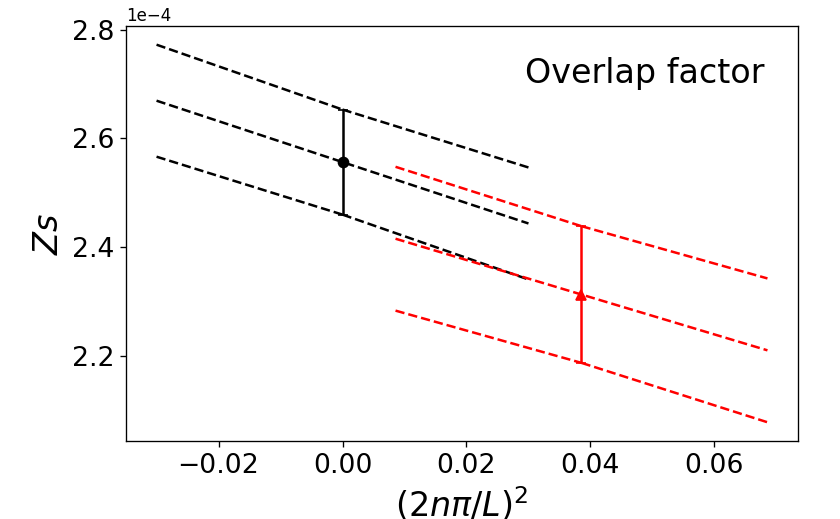

<IPython.core.display.Javascript object>


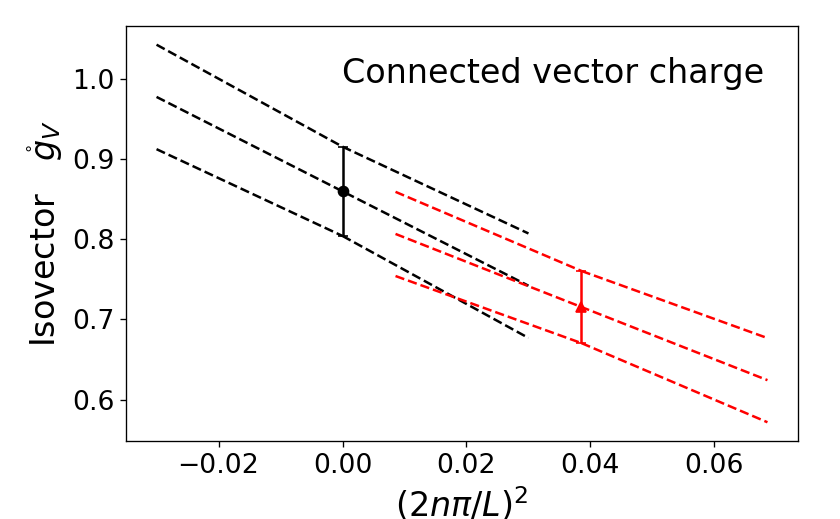

slope: -3.93(32)
slope: -3.04(25)


In [12]:
smears = [i.lower() for i in np.unique(list(''.join(switches['fit']['snk_src'])))]
qlabel = dict()
qlabel[0] = dict()
qlabel[0]['marker'] = 'o'
qlabel[0]['color'] = 'black'
qlabel[1] = dict()
qlabel[1]['marker'] = '^'
qlabel[1]['color'] = 'red'
qlabel[2] = dict()
qlabel[2]['marker'] = 's'
qlabel[2]['color'] = 'blue'
slope_l = 0.03
for s in smears:
    if 'nucleon' in switches['fit']['clist']:
        fig = plt.figure('Z%s' %s,figsize=(7,4.326237))
        ax = plt.axes([0.15,0.15,0.8,0.8])
        for n in phys['Z'][s].keys():
            p2 = (2*np.pi*n/nl)**2
            Z = phys['Z'][s][n]
            ax.errorbar(x=p2,y=Z.mean,yerr=Z.sdev,color=qlabel[n]['color'],marker=qlabel[n]['marker'],capsize=3)
            try:
                dZ = phys['dZ'][s][n]
                # plot central slope
                x = np.array([p2-slope_l,p2,p2+slope_l])
                slope = Z.mean+dZ.mean*(x-p2)
                ax.errorbar(x=x,y=slope,color=qlabel[n]['color'],marker='None',ls='--')
                # plot right side slope
                xp = np.array([p2,p2+slope_l])
                pp = (Z.mean+Z.sdev)+(dZ.mean+dZ.sdev)*(xp-p2)
                ax.errorbar(x=xp,y=pp,color=qlabel[n]['color'],marker='None',ls='--')
                pm = (Z.mean-Z.sdev)+(dZ.mean-dZ.sdev)*(xp-p2)
                ax.errorbar(x=xp,y=pm,color=qlabel[n]['color'],marker='None',ls='--')
                # plot left side slope
                xm = np.array([p2-slope_l,p2])
                mp = (Z.mean+Z.sdev)+(dZ.mean-dZ.sdev)*(xm-p2)
                ax.errorbar(x=xm,y=mp,color=qlabel[n]['color'],marker='None',ls='--')
                mm = (Z.mean-Z.sdev)+(dZ.mean+dZ.sdev)*(xm-p2)
                ax.errorbar(x=xm,y=mm,color=qlabel[n]['color'],marker='None',ls='--')
            except:
                pass
        ax.set_title("Overlap factor",fontdict={'fontsize':20,'verticalalignment':'top','horizontalalignment':'right'},x=0.95,y=0.9)
        ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
        ax.set_xlabel('$(2n\pi/L)^2$', fontsize=20)
        ax.set_ylabel('$Z%s$' %s, fontsize=20)
        ax.xaxis.set_tick_params(labelsize=16)
        ax.yaxis.set_tick_params(labelsize=16)
        fig.savefig('./Z%s.pdf' %s,transparent=True)
if 'gV' in switches['fit']['clist']:
    fig = plt.figure('gV',figsize=(7,4.326237))
    ax = plt.axes([0.15,0.15,0.8,0.8])
    for n in phys['gV'].keys():
        p2 = (2*np.pi*n/nl)**2
        V = phys['gV'][n]
        ax.errorbar(x=p2,y=V.mean,yerr=V.sdev,color=qlabel[n]['color'],marker=qlabel[n]['marker'],capsize=3)
        try:
            dV = phys['dgV'][n]
            print("slope:",dV)
            # plot central slope
            x = np.array([p2-slope_l,p2,p2+slope_l])
            slope = V.mean+dV.mean*(x-p2)
            ax.errorbar(x=x,y=slope,color=qlabel[n]['color'],marker='None',ls='--')
            # plot right side slope
            xp = np.array([p2,p2+slope_l])
            pp = (V.mean+V.sdev)+(dV.mean+dV.sdev)*(xp-p2)
            ax.errorbar(x=xp,y=pp,color=qlabel[n]['color'],marker='None',ls='--')
            pm = (V.mean-V.sdev)+(dV.mean-dV.sdev)*(xp-p2)
            ax.errorbar(x=xp,y=pm,color=qlabel[n]['color'],marker='None',ls='--')
            # plot left side slope
            xm = np.array([p2-slope_l,p2])
            mp = (V.mean+V.sdev)+(dV.mean-dV.sdev)*(xm-p2)
            ax.errorbar(x=xm,y=mp,color=qlabel[n]['color'],marker='None',ls='--')
            mm = (V.mean-V.sdev)+(dV.mean+dV.sdev)*(xm-p2)
            ax.errorbar(x=xm,y=mm,color=qlabel[n]['color'],marker='None',ls='--')
        except:
            pass
    ax.set_title("Connected vector charge",fontdict={'fontsize':20,'verticalalignment':'top','horizontalalignment':'right'},x=0.95,y=0.9)
    ax.set_xlabel('$(2n\pi/L)^2$', fontsize=20)
    ax.set_ylabel('$\mathrm{Isovector}\quad\mathring{g}_{V}$', fontsize=20)
    ax.xaxis.set_tick_params(labelsize=16)
    ax.yaxis.set_tick_params(labelsize=16)
    fig.savefig('./gV.pdf',transparent=True)

In [13]:
dV = -6*phys['dgV'][0]*(0.12)**2/(2*phys['E'][0])
print("slope:",dV)

slope: 0.232(18)


# read result to plot

<IPython.core.display.Javascript object>


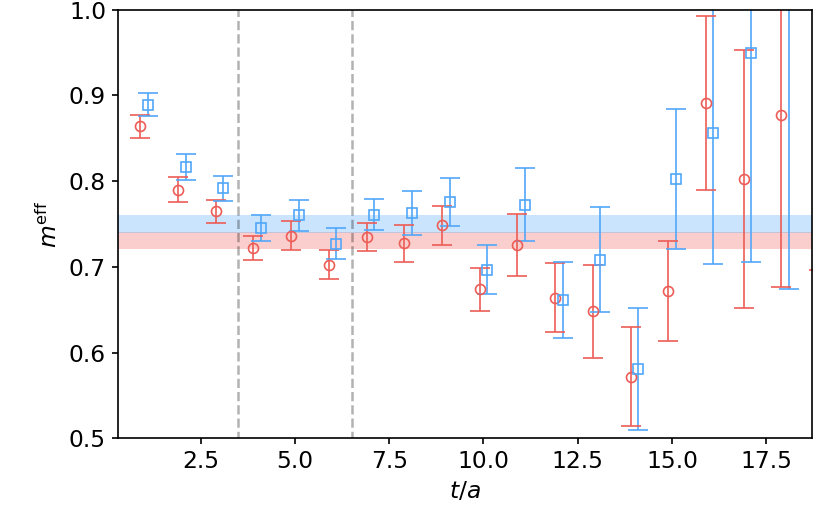

/Users/cchang5/anaconda/envs/pyqcd3/lib/python3.6/site-packages/ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in log


<IPython.core.display.Javascript object>


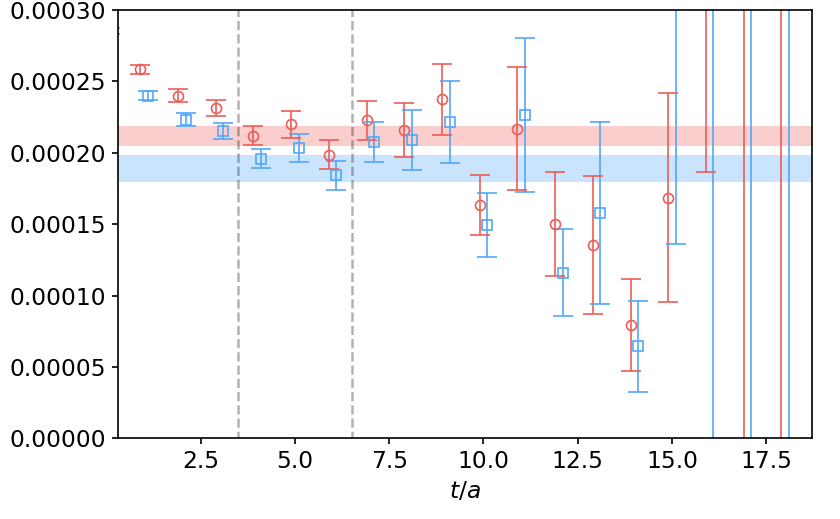

/Users/cchang5/anaconda/envs/pyqcd3/lib/python3.6/site-packages/ipykernel_launcher.py:82: RuntimeWarning: invalid value encountered in log
/Users/cchang5/anaconda/envs/pyqcd3/lib/python3.6/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in sqrt


<IPython.core.display.Javascript object>


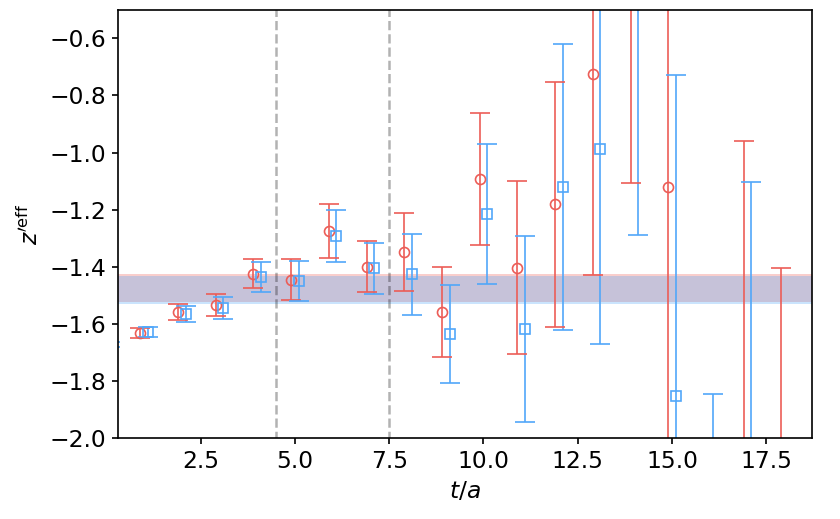

/Users/cchang5/anaconda/envs/pyqcd3/lib/python3.6/site-packages/ipykernel_launcher.py:117: RuntimeWarning: invalid value encountered in log
/Users/cchang5/anaconda/envs/pyqcd3/lib/python3.6/site-packages/ipykernel_launcher.py:118: RuntimeWarning: invalid value encountered in sqrt


<IPython.core.display.Javascript object>


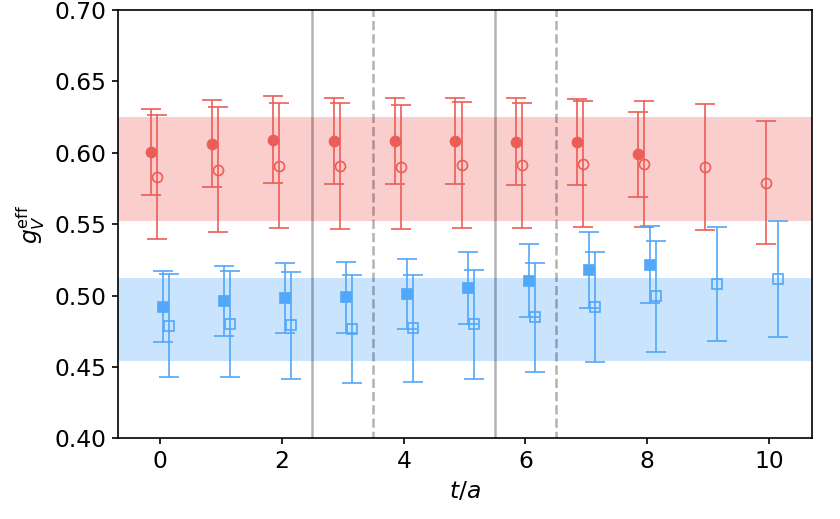

/Users/cchang5/anaconda/envs/pyqcd3/lib/python3.6/site-packages/ipykernel_launcher.py:168: RuntimeWarning: invalid value encountered in log
/Users/cchang5/anaconda/envs/pyqcd3/lib/python3.6/site-packages/ipykernel_launcher.py:169: RuntimeWarning: invalid value encountered in log
/Users/cchang5/anaconda/envs/pyqcd3/lib/python3.6/site-packages/ipykernel_launcher.py:170: RuntimeWarning: invalid value encountered in sqrt
/Users/cchang5/anaconda/envs/pyqcd3/lib/python3.6/site-packages/ipykernel_launcher.py:171: RuntimeWarning: invalid value encountered in sqrt


<IPython.core.display.Javascript object>


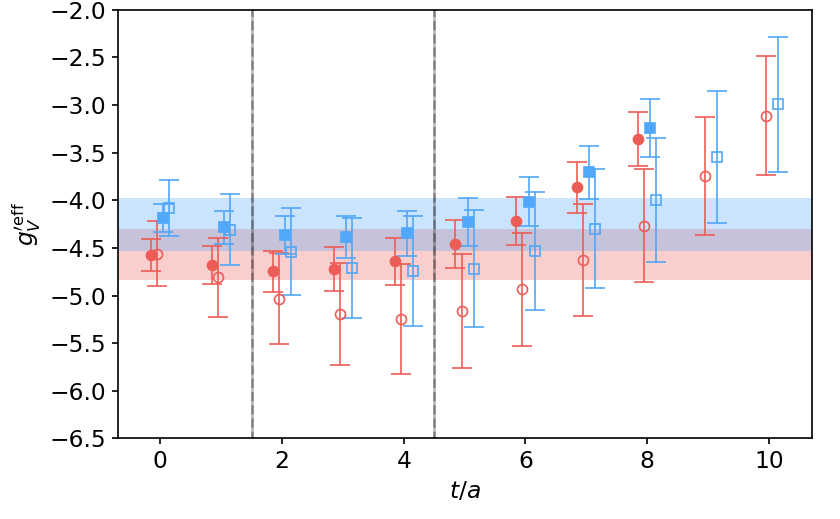

/Users/cchang5/anaconda/envs/pyqcd3/lib/python3.6/site-packages/ipykernel_launcher.py:224: RuntimeWarning: invalid value encountered in log
/Users/cchang5/anaconda/envs/pyqcd3/lib/python3.6/site-packages/ipykernel_launcher.py:225: RuntimeWarning: invalid value encountered in sqrt


In [15]:
# plot params
figsize = (3.50394*2,2*2.1655535534)
ms = '6'
cs = 6
fs_l = 14
fs_xy = 14
ts = 14
lw = 1
plt_axes = [0.14,0.155,0.825,0.825]
# state and q label
pparam = dict()
# state
pparam['color'] = dict()
pparam['color']['q0'] = '#ec5d57' # red
#pparam['color']['2state'] = '#70bf41' # green
pparam['color']['q1'] = '#51a7f9' # blue
#pparam['color']['4state'] = '#b36ae2' # purple
# q
pparam['shape'] = dict()
pparam['shape']['q0'] = 'o'
pparam['shape']['q1'] = 's'
# label translator
pparam['label'] = dict()
pparam['label']['2pt'] = 'C_{\mathrm{2pt}}(t)'
pparam['label']['d2pt'] = 'C^\prime_{\mathrm{2pt}}(t)'
pparam['label']['gV8'] = 'C_{\mathrm{3pt}}(8,t^\prime)'
pparam['label']['dgV8'] = 'C^\prime_{\mathrm{3pt}}(8,t^\prime)'
pparam['label']['gV10'] = 'C_{\mathrm{3pt}}(10,t^\prime)'
pparam['label']['dgV10'] = 'C^\prime_{\mathrm{3pt}}(10,t^\prime)'
dat2name = [i for i in gvdata.keys() if i.split('_')[0] in ['nucleon']]
datd2name = [i for i in gvdata.keys() if i.split('_')[0] in ['dnucleon']]
dat3name = [i for i in gvdata.keys() if i.split('_')[0] in ['gV']]
datd3name = [i for i in gvdata.keys() if i.split('_')[0] in ['dgV']]

post = result[list(result.keys())[0]]['fit'].p
# plot effective mass correlator
fig = plt.figure('meffx',figsize=figsize)
ax = plt.axes(plt_axes)
x = np.arange(0,24)
xmin = switches['fit']['trange']['nucleon_tmin'][0]-0.5
xmax = switches['fit']['trange']['nucleon_tmax'][0]+0.5
ax.errorbar(x=[xmin,xmin],y=[-10,10],ls='--',color='black',alpha=0.3)
ax.errorbar(x=[xmax,xmax],y=[-10,10],ls='--',color='black',alpha=0.3)
E00 = post['E0_q0']
ax.fill_between([-1,20],E00.mean-E00.sdev,E00.mean+E00.sdev,alpha=0.3,facecolor=pparam['color']['q0']) # q=0
try:
    E01 = post['E0_q1']
    ax.fill_between([-1,20],E01.mean-E01.sdev,E01.mean+E01.sdev,alpha=0.3,facecolor=pparam['color']['q1']) # q=1
except: pass
for d in dat2name:
    meff = np.log(gvdata[d]/np.roll(gvdata[d],-1))[x]
    ax.errorbar(x+0.2*(float(d[-1])-0.5),y=[i.mean for i in meff],yerr=[i.sdev for i in meff],\
                label=d,marker=pparam['shape']['q%s' %d[-1]],color=pparam['color']['q%s' %d[-1]],\
               capsize=cs,markersize=ms,elinewidth=lw,mew=lw,fillstyle='none', ls='none')
#ax.legend()
ax.set_xlabel(r'$t/a$', fontsize=fs_xy)
ax.set_ylabel(r'$m^{\mathrm{eff}}$', fontsize=fs_xy)
ax.set_xlim([0.3,18.7])
ax.set_ylim([0.5,1.0])
#ax.set_xticks(xticks)
ax.xaxis.set_tick_params(labelsize=ts,width=lw)
ax.yaxis.set_tick_params(labelsize=ts,width=lw)
[ax.spines[key].set_linewidth(lw) for key in ax.spines]
fig.savefig('./paper/plots/figures/meff.pdf', transparent=True)
plt.draw()

# plot scaled two point correlator
fig = plt.figure('zeffx',figsize=figsize)
ax = plt.axes(plt_axes)
x = np.arange(0,24)
xmin = switches['fit']['trange']['nucleon_tmin'][0]-0.5
xmax = switches['fit']['trange']['nucleon_tmax'][0]+0.5
ax.errorbar(x=[xmin,xmin],y=[-1,1],ls='--',color='black',alpha=0.3)
ax.errorbar(x=[xmax,xmax],y=[-1,1],ls='--',color='black',alpha=0.3)
Z00 = post['Z0s_q0']
ax.fill_between([-1,20],Z00.mean-Z00.sdev,Z00.mean+Z00.sdev,alpha=0.3,facecolor=pparam['color']['q0']) # q=0
try:
    Z01 = post['Z0s_q1']
    ax.fill_between([-1,20],Z01.mean-Z01.sdev,Z01.mean+Z01.sdev,alpha=0.3,facecolor=pparam['color']['q1']) # q=1
except: pass
for d in dat2name:
    snk_src = d.split('_')[1]
    if snk_src in ['SS','PP']:
        meff = np.log(gvdata[d]/np.roll(gvdata[d],-1))
        scor = np.sqrt(gvdata[d]*np.exp(meff*np.arange(len(meff))))[x]
        ax.errorbar(x+0.2*(float(d[-1])-0.5),y=[i.mean for i in scor],yerr=[i.sdev for i in scor],label=d,\
                    marker=pparam['shape']['q%s' %d[-1]],color=pparam['color']['q%s' %d[-1]],\
                    capsize=cs,markersize=ms,elinewidth=lw,mew=lw,fillstyle='none', ls='none')
    else:
        pass
#ax.legend()
ax.set_xlabel(r'$t/a$', fontsize=fs_xy)
ax.set_ylabel(r'$z^{\mathrm{eff}}$', fontsize=fs_xy)
#ax.set_xticks(xticks)
ax.xaxis.set_tick_params(labelsize=ts,width=lw)
ax.yaxis.set_tick_params(labelsize=ts,width=lw)
ax.set_xlim([0.3,18.7])
ax.set_ylim([0,3E-4])
[ax.spines[key].set_linewidth(lw) for key in ax.spines]
fig.savefig('./paper/plots/figures/zeff.pdf', transparent=True)
plt.draw()

# plot two point slope
fig = plt.figure('zeffprimex',figsize=figsize)
ax = plt.axes(plt_axes)
x = np.arange(0,24)
xmin = switches['fit']['trange']['dnucleon_tmin'][0]-0.5
xmax = switches['fit']['trange']['dnucleon_tmax'][0]+0.5
ax.errorbar(x=[xmin,xmin],y=[-10,1],ls='--',color='black',alpha=0.3)
ax.errorbar(x=[xmax,xmax],y=[-10,1],ls='--',color='black',alpha=0.3)
Y00 = post['Y0s_q0']
ax.fill_between([0,30],Y00.mean-Y00.sdev,Y00.mean+Y00.sdev,alpha=0.3,facecolor=pparam['color']['q0']) # q=0
try:
    Y01 = post['Y0s_q1']
    ax.fill_between([0,30],Y01.mean-Y01.sdev,Y01.mean+Y01.sdev,alpha=0.3,facecolor=pparam['color']['q1']) # q=1
except: pass
for dd in datd2name:
    snk_src = dd.split('_')[1]
    d = dd[1:] # two point name (take out derivative)
    if snk_src in ['SS','PP']:
        meff = np.log(gvdata[d]/np.roll(gvdata[d],-1))
        scor = np.sqrt(gvdata[d]*np.exp(meff*np.arange(len(meff))))
        dcor = ((gvdata[dd]/gvdata[d]+0.5/meff**2+0.5*np.arange(len(meff))/meff)*0.5)[x]
        ax.errorbar(x+0.2*(float(d[-1])-0.5),y=[i.mean for i in dcor],yerr=[i.sdev for i in dcor],label=dd,\
                    marker=pparam['shape']['q%s' %d[-1]],color=pparam['color']['q%s' %d[-1]],\
                    capsize=cs,markersize=ms,elinewidth=lw,mew=lw,fillstyle='none', ls='none')
    else:
        pass
#ax.legend()
ax.set_xlabel(r'$t/a$', fontsize=fs_xy)
ax.set_ylabel(r'$z^{\prime\mathrm{eff}}$', fontsize=fs_xy)
ax.set_xlim([0.3,18.7])
ax.set_ylim([-2,-0.5])
#ax.set_xticks(xticks)
ax.xaxis.set_tick_params(labelsize=ts,width=lw)
ax.yaxis.set_tick_params(labelsize=ts,width=lw)
[ax.spines[key].set_linewidth(lw) for key in ax.spines]
fig.savefig('./paper/plots/figures/dzeff.pdf', transparent=True)
plt.draw()

# plot three point correlator
fig = plt.figure('gV correlatorx',figsize=figsize)
ax = plt.axes(plt_axes)
for d in dat3name:
    snk_src = d.split('_')[1]
    Tx = d.split('_')[2]
    T = int(Tx[1:])
    qx = d.split('_')[3]
    q = int(qx[1:])
    x = np.arange(T+1)
    xmin8 = switches['fit']['trange']['gV_T%s_tmin' %T][0]-0.5
    xmax8 = switches['fit']['trange']['gV_T%s_tmax' %T][0]+0.5
    if q == 0:
        if T == 8: ls = '-'
        elif T == 10: ls = '--'
        ax.errorbar(x=[xmin8,xmin8],y=[-10,10],ls=ls,color='black',alpha=0.3)
        ax.errorbar(x=[xmax8,xmax8],y=[-10,10],ls=ls,color='black',alpha=0.3)
g00 = post['V00_q0']
ax.fill_between([-10,30],g00.mean-g00.sdev,g00.mean+g00.sdev,alpha=0.3,facecolor=pparam['color']['q0']) # q=0
try:
    g01 = post['V00_q1']
    ax.fill_between([-10,30],g01.mean-g01.sdev,g01.mean+g01.sdev,alpha=0.3,facecolor=pparam['color']['q1']) # q=1
except: pass
for d in dat3name:
    snk_src = d.split('_')[1]
    Tx = d.split('_')[2]
    T = int(Tx[1:])
    qx = d.split('_')[3]
    q = int(qx[1:])
    if snk_src in ['SS','PP']:
        d2 = d.replace('gV','nucleon').replace('_%s' %Tx,'') # two point correlator name
        d20 = d2.replace(qx,'q0') # zero momentum two point name
        Tlist = np.arange(len(gvdata[d2]))
        Esnk = np.mean(np.log(gvdata[d20]/np.roll(gvdata[d20],-1))[6:9]) # sink is always at zero momentum
        Esrc = np.mean(np.log(gvdata[d2]/np.roll(gvdata[d2],-1))[6:9])
        Zsnk = np.mean(np.sqrt(gvdata[d20]*np.exp(Esnk*Tlist))[6:9]) # sink is always at zero momentum
        Zsrc = np.mean(np.sqrt(gvdata[d2]*np.exp(Esrc*Tlist))[6:9])
        tlist = np.arange(len(gvdata[d]))
        geff = (gvdata[d]*np.exp(Esnk*T)*np.exp((Esrc-Esnk)*tlist)/(Zsnk*Zsrc))[x]
        if T == 8: fs = 'full'
        elif T == 10: fs = 'none'
        ax.errorbar(x+(0.2*q-0.1)+0.05*(T-9),y=[i.mean for i in geff],yerr=[i.sdev for i in geff],label=d,\
                    marker=pparam['shape']['q%s' %d[-1]],color=pparam['color']['q%s' %d[-1]],\
                    capsize=cs,markersize=ms,elinewidth=lw,mew=lw,fillstyle=fs, ls='none')
        #ax.legend()
ax.set_xlabel(r'$t/a$', fontsize=fs_xy)
ax.set_ylabel(r'$g_V^{\mathrm{eff}}$', fontsize=fs_xy)
ax.set_xlim([-0.7,T+0.7])
ax.set_ylim([0.4,0.7])
#ax.set_xticks(xticks)
ax.xaxis.set_tick_params(labelsize=ts,width=lw)
ax.yaxis.set_tick_params(labelsize=ts,width=lw)
[ax.spines[key].set_linewidth(lw) for key in ax.spines]
fig.savefig('./paper/plots/figures/gVeff.pdf', transparent=True)
plt.draw()

# plot three point derivative correlator
fig = plt.figure('dgV correlatorx',figsize=figsize)
ax = plt.axes(plt_axes)
for d in dat3name:
    snk_src = d.split('_')[1]
    Tx = d.split('_')[2]
    T = int(Tx[1:])
    qx = d.split('_')[3]
    q = int(qx[1:])
    x = np.arange(T+1)
    xmin8 = switches['fit']['trange']['dgV_T%s_tmin' %T][0]-0.5
    xmax8 = switches['fit']['trange']['dgV_T%s_tmax' %T][0]+0.5
    if q == 0:
        if T == 8: ls = '-'
        elif T == 10: ls = '--'
        ax.errorbar(x=[xmin8,xmin8],y=[-10,10],ls=ls,color='black',alpha=0.3)
        ax.errorbar(x=[xmax8,xmax8],y=[-10,10],ls=ls,color='black',alpha=0.3)
dg00 = post['U00_q0']
ax.fill_between([-10,30],dg00.mean-dg00.sdev,dg00.mean+dg00.sdev,alpha=0.3,facecolor=pparam['color']['q0']) # q=0
try:
    dg01 = post['U00_q1']
    ax.fill_between([-10,30],dg01.mean-dg01.sdev,dg01.mean+dg01.sdev,alpha=0.3,facecolor=pparam['color']['q1']) # q=1
except: pass
for dd in datd3name:
    d = dd[1:] # three point correlator name
    snk_src = dd.split('_')[1]
    Tx = dd.split('_')[2]
    T = int(Tx[1:])
    qx = dd.split('_')[3]
    q = int(qx[1:])
    x = np.arange(T+1)
    if snk_src in ['SS','PP']:
        d2 = d.replace('gV','nucleon').replace('_%s' %Tx,'') # two point correlator name
        dd2 = 'd%s' %d2 # two point derivative name
        Tlist = np.arange(len(gvdata[d2]))
        Esrc = np.log(gvdata[d2]/np.roll(gvdata[d2],-1))
        Zsrc = np.sqrt(gvdata[d2]*np.exp(Esrc*Tlist))
        dZsrc = ((gvdata[dd2]/gvdata[d2]+0.5/Esrc**2+0.5*np.arange(len(Esrc))/Esrc)*0.5)
        #Etmin = switches['fit']['trange']['nucleon_tmin'][0]
        #Etmax = switches['fit']['trange']['nucleon_tmax'][0]
        Emean = post['E0_q%s' %str(q)] #np.mean(Esrc[Etmin:Etmax+1])
        #dZtmin = switches['fit']['trange']['dnucleon_tmin'][0]
        #dZtmax = switches['fit']['trange']['dnucleon_tmax'][0]
        dZmean = post['Y0s_q%s' %str(q)] #np.mean(dZsrc[dZtmin:dZtmax+1])
        tlist = np.arange(len(gvdata[d]))
        dgeff = (gvdata[dd]/gvdata[d]-dZmean+0.5/Emean**2+0.5*tlist/Emean)[x]
        if T == 8: fs = 'full'
        elif T == 10: fs = 'none'
        #ax.errorbar(x+0.1*q,y=[i.mean for i in dgeff],yerr=[i.sdev for i in dgeff],label=d,capsize=4,marker='o')
        ax.errorbar(x+(0.2*q-0.1)+0.05*(T-9),y=[i.mean for i in dgeff],yerr=[i.sdev for i in dgeff],label=d,\
                    marker=pparam['shape']['q%s' %d[-1]],color=pparam['color']['q%s' %d[-1]],\
                    capsize=cs,markersize=ms,elinewidth=lw,mew=lw,fillstyle=fs, ls='none')
        #ax.legend()
ax.set_xlabel(r'$t/a$', fontsize=fs_xy)
ax.set_ylabel(r'$g_V^{\prime\mathrm{eff}}$', fontsize=fs_xy)
ax.set_xlim([-0.7,T+0.7])
ax.set_ylim([-6.5,-2])
#ax.set_xticks(xticks)
ax.xaxis.set_tick_params(labelsize=ts,width=lw)
ax.yaxis.set_tick_params(labelsize=ts,width=lw)
[ax.spines[key].set_linewidth(lw) for key in ax.spines]
fig.savefig('./paper/plots/figures/dgVeff.pdf', transparent=True)
plt.draw()